In [10]:
import os
import sys
import toml

from ipywidgets import interactive, IntSlider
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import numpy as np
import polars as pl
import sqlite3
import torch

if '../' not in sys.path:
    sys.path.append('../')

In [11]:
from axe.lsm.cost import Cost
from axe.lsm.types import Policy, System, LSMDesign, LSMBounds, Workload
from axe.lcm.data.schema import LCMDataSchema, kWORKLOAD_HEADER, kSYSTEM_HEADER
from axe.ltuner.data.schema import LTunerDataSchema
from experiments.evaluate_ltuner import LTunerEvaluator

In [12]:
SYS_COL = kSYSTEM_HEADER
WL_COL = kWORKLOAD_HEADER

Settings to force LaTeX style font within matplotlib plots

In [13]:
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r'\usepackage{amsmath}\usepackage{amssymb}'
plt.rcParams["font.family"] = r'serif'
plt.rcParams["font.serif"] = r'Computer Modern'

golden_ratio = (1 + 5 ** 0.5) / 2
cm_to_in = 1/2.54  # centimeters in inches
width = 8.45 * cm_to_in
height = width / golden_ratio

def save_fig(fig, filename):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight')

In [29]:
connection = sqlite3.connect("../data/axe_vldb_mlos_with_init.db")
env_table = pl.read_database("SELECT * FROM environments;", connection)
mlos_table = pl.read_database("SELECT * FROM mlos_tunings;", connection)
monkey_table = pl.read_database("SELECT * FROM monkey_evaluation;", connection)

If we want to load in a model and perform the experiment, we can do it with the evaluator

In [31]:
model_path = "../data/ltuner/models/kaplsm_250514_1230/"
config = toml.load(os.path.join(model_path, "axe.toml"))
policy = getattr(Policy, config['lsm']['policy'])
bounds = LSMBounds(**config['lsm']['bounds'])
ltune_schema = LTunerDataSchema(policy=policy, bounds=bounds)
lcm_schema = LCMDataSchema(policy=policy, bounds=bounds)
cost_fn = Cost(bounds.max_considered_levels)

# "Redoing" the experiment
# evaluator = LTunerEvaluator(config, model_path=model_path, model_name="checkpoints/epoch01.model")
# evaluator = LTunerEvaluator(config, model_path=model_path, model_name="best_model.model")
# input_table = pl.read_database("SELECT * FROM environments;", connection)
# ltune_rep_table = evaluator.evaluate(input_table)

# Assuming its in the DB we can
ltune_rep_table = pl.read_database("SELECT * FROM ltune_eval_rep;", connection)

In [32]:
def row_to_objs(row: dict):
    workload = Workload(
        row["empty_reads"],
        row["non_empty_reads"],
        row["range_queries"],
        row["writes"],
    )
    system = System(
        entries_per_page=row["entries_per_page"],
        selectivity=row["selectivity"],
        entry_size=row["entry_size"],
        mem_budget=row["mem_budget"],
        num_entries=row["num_entries"],
    )
    return workload, system   

In [33]:
def load_camal_table(path):
    camal_table= pl.read_csv(path)
    camal_data = camal_table.filter(pl.col('optimizer') == "lr").head(15).to_dicts()
    camal_designs = [
        LSMDesign(
            bits_per_elem=row["h"],
            size_ratio=row["T"],
            policy=(Policy.Leveling if row["is_leveling_policy"] else Policy.Tiering),
            kapacity=()
        )
        for row in camal_data
    ]
    camal_perf_table = []
    for env, design in zip(env_table.to_dicts(), camal_designs):
        workload, system = row_to_objs(env)
        row = LTunerDataSchema.design_to_dict(design)
        row["cost"] = cost_fn.calc_cost(design, system, workload)
        camal_perf_table.append(row)
    camal_perf_table = pl.concat((env_table, pl.DataFrame(camal_perf_table)), how='horizontal')

    return camal_perf_table

In [34]:
camal_perf_table = load_camal_table('../data/camal_optimizer_uniform.csv')
camal_perf_table

env_id,empty_reads,non_empty_reads,range_queries,writes,entry_size,selectivity,entries_per_page,num_entries,mem_budget,read_write_asym,bits_per_elem,size_ratio,policy,cost
i64,f64,f64,f64,f64,i64,f64,i64,i64,f64,f64,f64,i64,str,f64
1,0.25,0.25,0.25,0.25,8192,0.0000004,4,1000000000,10.0,1.0,1.2,2,"""Policy.Leveling""",29.697218
2,0.97,0.01,0.01,0.01,8192,0.0000004,4,1000000000,10.0,1.0,1.2,2,"""Policy.Leveling""",3.343236
3,0.01,0.97,0.01,0.01,8192,0.0000004,4,1000000000,10.0,1.0,6.0,83,"""Policy.Tiering""",5.792324
4,0.01,0.01,0.97,0.01,8192,0.0000004,4,1000000000,10.0,1.0,1.2,2,"""Policy.Leveling""",106.657372
5,0.01,0.01,0.01,0.97,8192,0.0000004,4,1000000000,10.0,1.0,8.0,94,"""Policy.Leveling""",42.762357
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11,0.01,0.01,0.49,0.49,8192,0.0000004,4,1000000000,10.0,1.0,1.2,2,"""Policy.Leveling""",56.290001
12,0.33,0.33,0.33,0.01,8192,0.0000004,4,1000000000,10.0,1.0,1.2,2,"""Policy.Leveling""",37.622081
13,0.33,0.33,0.01,0.33,8192,0.0000004,4,1000000000,10.0,1.0,5.4,2,"""Policy.Leveling""",3.351225


In [35]:
# camal_perf_table.to_pandas().to_sql(name="camal_tunings", con=connection, index=False)

# Experiment outline

1. Train a LTune model
2. Start with a clean BO model
3. Pick a workload, w, that both models have not seen
4. Train BO model, while capturing the designs at each round (round <- (suggest, cost, register))
5. Plot performance of each round, and the performance of a single LTune suggestion for w

In [36]:
def get_tuning_costs(env_id):
    ltuner_cost = ltune_rep_table.filter(pl.col('env_id') == env_id)["cost"][0]
    solver_cost = ltune_rep_table.filter(pl.col('env_id') == env_id)["cost_solver"][0]
    camal_cost = camal_perf_table.filter(pl.col('env_id') == env_id)["cost"][0]
    monkey_cost = monkey_table.filter(pl.col('env_id') == env_id)["cost"][0]
    return (solver_cost, ltuner_cost, camal_cost, monkey_cost)

In [37]:
def get_data(env_id):
    env = env_table.filter(pl.col('env_id') == env_id)
    wl = Workload(*env.select(WL_COL).rows()[0])
    system = System(*env.select(SYS_COL).rows()[0])
    ltuner_cost, solver_cost, camal_cost, monkey_cost = get_tuning_costs(env_id)
    
    group = mlos_table.filter(pl.col('env_id') == env_id).group_by('round').agg(
        pl.col('cost').mean().alias('mean'),
        pl.col('cost').std().alias('std'),
        pl.col('cost').count().alias('count')
    )
    group = group.with_columns(ci=(1.96 * pl.col('std') / pl.col('count').sqrt()))
    group = group.with_columns(
        ci_lower=(pl.col('mean') - pl.col('ci')),
        ci_upper=(pl.col('mean') + pl.col('ci')),
        ltuner_cost=ltuner_cost,
        solver_cost=solver_cost,
        camal_cost=camal_cost,
        monkey_cost=monkey_cost
    ).sort(by='round')

    return group, wl, system

In [38]:
def plot_env(env_id: int = 1):
    group, wl, system = get_data(env_id)
    opt_cost = ltune_rep_table.filter(pl.col('env_id') == env_id)['cost_solver'][0]
    monkey_cost = monkey_table.filter(pl.col('env_id') == env_id)['cost'][0]
    camal_cost = camal_perf_table.filter(pl.col('env_id') == env_id)['cost'][0]

    fig, ax = plt.subplots()
    ax.plot(group['round'], group['mean'], label='BO (Kap)', color='tab:gray', marker='o')
    ax.fill_between(group['round'], group['ci_lower'], group['ci_upper'], color='tab:gray', alpha=.25)
    ax.hlines(y=group["ltuner_cost"][0], xmin=0, xmax=group['round'].max(), label='AXE', color='tab:green', linestyle='-')
    ax.hlines(y=group["monkey_cost"][0], xmin=0, xmax=group['round'].max(), label='Monkey (T/L)', color='tab:blue', linestyle='-.')
    # ax.hlines(y=group["solver_cost"][0], xmin=0, xmax=group['round'].max(), label='Optimizer (Kap)', color='tab:orange', linestyle='--')
    ax.hlines(y=group["camal_cost"][0], xmin=0, xmax=group['round'].max(), label='CAMAL (T/L)', color='tab:brown', linestyle=':')
    ax.legend()
    ax.set_ylabel('Estimate Cost (Avg I/O per Query)')
    ax.set_xlabel('Rounds')
    ax.set_title(f'Workload: $w_{{{env_id - 1}}} = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$')
    plt.show()

    return env_id, wl, system, fig, ax

In [39]:
id_widget = IntSlider(min=1, max=len(env_table), step=1)
iplot_env = interactive(plot_env, env_id=id_widget)
iplot_env

interactive(children=(IntSlider(value=1, description='env_id', max=15, min=1), Output()), _dom_classes=('widge…

In [40]:
# env_id = 1
# group, wl, system = get_data(env_id)
# ltuner_cost, solver_cost, camal_cost, monkey_cost = get_tuning_costs(env_id)

# fig, ax = plt.subplots(figsize=(1.25*width, 1*height))
# ax.plot(group['round'], group['mean'], label='BO', color='tab:gray', marker='', markevery=5)
# ax.fill_between(group['round'], group['ci_lower'], group['ci_upper'], color='tab:gray', alpha=.25)
# ax.hlines(y=ltuner_cost, xmin=0, xmax=group['round'].max(), label='AXE', color='tab:green', linestyle='-')
# ax.hlines(y=monkey_cost, xmin=0, xmax=group['round'].max(), label='Monkey', color='tab:blue', linestyle='-.')
# ax.hlines(y=camal_cost, xmin=0, xmax=group['round'].max(), label='CAMAL', color='tab:brown', linestyle='--')
# ax.legend(ncols=2)
# ax.set_ylabel('Avg I/O per Query')
# ax.set_xlabel('Rounds')
# # ax.set_yticks([x for x in range(6, 18, 2)])
# ax.set_title(f'$w_{{{env_id - 1}}} = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$')
# plt.show()
# # save_fig(fig, 'uniform_workload.pdf')

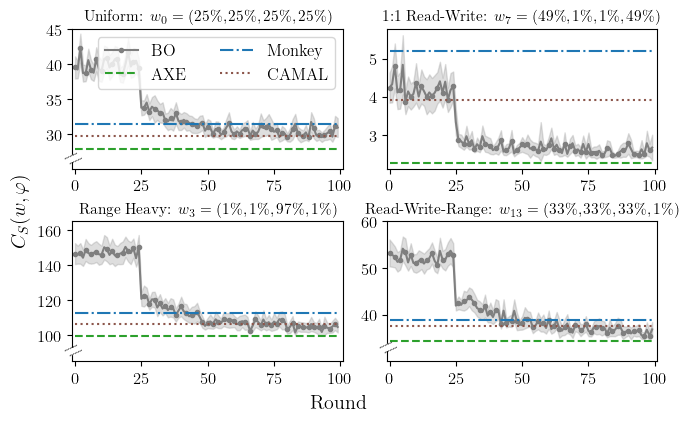

In [47]:
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(2*width, 2*height), constrained_layout=True)

data, wl, _ = get_data(1)
ax = axes[0, 0]
ax.plot(data['round'], data['mean'], label='BO', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltuner_cost'][0], xmin=0, xmax=data['round'].max(), label='AXE', color='tab:green', linestyle='--')
ax.hlines(y=data["monkey_cost"][0], xmin=0, xmax=data['round'].max(), label='Monkey', color='tab:blue', linestyle='-.')
ax.hlines(y=data["camal_cost"][0], xmin=0, xmax=data['round'].max(), label='CAMAL', color='tab:brown', linestyle=':')
ax.set_xlim([-1, 101])
ax.set_ylim([25, 45])
ax.set_yticks([30, 35, 40, 45])
ax.text(-4.5, 25.6, r'//', fontsize=10, weight=1000, rotation=-45, zorder=102)
ax.scatter(-1, 26.5, marker='s', s=25, clip_on=False, color='white', zorder=101)
ax.set_title(f'Uniform: $w_0 = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$', fontsize=11)
ax.legend(loc='upper right', ncols=2) # , bbox_to_anchor=(1.02, 1.05))

data, wl, _ = get_data(4)
ax = axes[1, 0]
ax.plot(data['round'], data['mean'], label='BO', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltuner_cost'][0], xmin=0, xmax=data['round'].max(), label='AXE', color='tab:green', linestyle='--')
ax.hlines(y=data["monkey_cost"][0], xmin=0, xmax=data['round'].max(), label='Monkey', color='tab:blue', linestyle='-.')
ax.hlines(y=data["camal_cost"][0], xmin=0, xmax=data['round'].max(), label='CAMAL', color='tab:brown', linestyle=':')
ax.set_xlim([-1, 101])
ax.set_ylim([85, 165])
ax.text(-4.5, 87.8, r'//', fontsize=10, weight=1000, rotation=-45, zorder=102)
ax.scatter(-1, 91, marker='s', s=25, clip_on=False, color='white', zorder=101)
ax.set_title(f'Range Heavy: $w_3 = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$', fontsize=11)

data, wl, _ = get_data(8)
ax = axes[0, 1]
ax.plot(data['round'], data['mean'], label='BO (95\\% CI)', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltuner_cost'][0], xmin=0, xmax=data['round'].max(), label='AXE', color='tab:green', linestyle='--')
ax.hlines(y=data["monkey_cost"][0], xmin=0, xmax=data['round'].max(), label='Monkey', color='tab:blue', linestyle='-.')
ax.hlines(y=data["camal_cost"][0], xmin=0, xmax=data['round'].max(), label='CAMAL', color='tab:brown', linestyle=':')
ax.set_xlim([-1, 101])
ax.set_title(f'1:1 Read-Write: $w_7 = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$', fontsize=11)

data, wl, _ = get_data(12)
ax = axes[1, 1]
ax.plot(data['round'], data['mean'], label='BO', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltuner_cost'][0], xmin=0, xmax=data['round'].max(), label='AXE', color='tab:green', linestyle='--')
ax.hlines(y=data["monkey_cost"][0], xmin=0, xmax=data['round'].max(), label='Monkey', color='tab:blue', linestyle='-.')
ax.hlines(y=data["camal_cost"][0], xmin=0, xmax=data['round'].max(), label='CAMAL', color='tab:brown', linestyle=':')
ax.set_xlim([-1, 101])
ax.set_ylim([30, 60])
ax.set_yticks([40, 50, 60])
ax.text(-4.5, 31.8, r'//', fontsize=10, weight=1000, rotation=-45, zorder=102)
ax.scatter(-1, 33, marker='s', s=25, clip_on=False, color='white', zorder=101)
ax.set_title(f'Read-Write-Range: $w_{{13}} = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$', fontsize=11)

fig.supxlabel('Round')
fig.supylabel(r'$C_S(w, \varphi)$')
save_fig(fig, 'bo_comparison_with_init.pdf')
# save_fig(fig, 'bo_comparison.pdf')
plt.show()

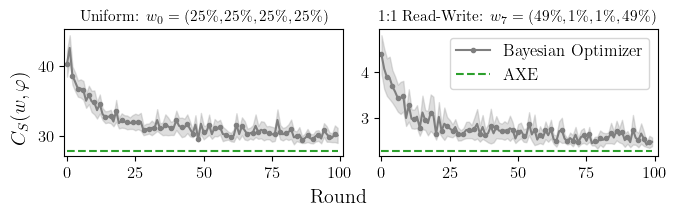

In [54]:
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(2*width, 1*height), constrained_layout=True)

data, wl, system = get_data(1)
ax = axes[0]
ax.plot(data['round'], data['mean'], label='Bayesian Optimizer', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltuner_cost'][0], xmin=0, xmax=data['round'].max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
# ax.set_ylim([25, 45])
# ax.set_yticks([30, 35, 40, 45])
# ax.text(-4.5, 25.6, r'//', fontsize=10, weight=1000, rotation=-45, zorder=102)
# ax.scatter(-1, 26.5, marker='s', s=25, clip_on=False, color='white', zorder=101)
ax.set_title(f'Uniform: $w_0 = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$', fontsize=11)
# ax.set_title(f'Uniform: $w_0$', fontsize=12)

data, wl, system = get_data(8)
ax = axes[1]
ax.plot(data['round'], data['mean'], label='Bayesian Optimizer', color='tab:gray', marker='.', markevery=2, rasterized=True)
ax.fill_between(data['round'], data['ci_lower'], data['ci_upper'], color='tab:gray', alpha=.25)
ax.hlines(y=data['ltuner_cost'][0], xmin=0, xmax=data['round'].max(), label='AXE', color='tab:green', linestyle='--')
ax.set_xlim([-1, 101])
ax.set_title(f'1:1 Read-Write: $w_7 = ({wl.z0*100:.0f}\\%, {wl.z1*100:.0f}\\%, {wl.q*100:.0f}\\%, {wl.w*100:.0f}\\%)$', fontsize=11)
ax.legend(loc='upper right') # , bbox_to_anchor=(1.02, 1.05))
# ax.set_title(f'1:1 Read-Write: $w_7$', fontsize=12)

fig.supxlabel('Round')
fig.supylabel(r'$C_S(w, \varphi)$')
# save_fig(fig, 'bo_comparison_with_init.pdf')
plt.show()

# Analyzing Trends

1. The first graph is a simple cutoff, we count the rounds up until Bayesian Optimization provides a configuration that is lower in expected cost than the design provided by LTune.

2. TODO: Come up with window criteria

In [57]:
# sql_query = """
#     SELECT
#         t.env_id,
#         t.trial,
#         MIN(t.round) as min_round
#     FROM tunings t
#     INNER JOIN learned_tunings lt ON t.env_id = lt.env_id
#     WHERE t.cost < lt.cost
#     GROUP BY t.env_id, t.trial;
#     """
# df = pd.read_sql(sql_query, connection)
# potential_total = pd.read_sql("SELECT COUNT(*) FROM (SELECT DISTINCT env_id, trial FROM tunings)", connection).values[0][0]
# data = df['min_round'].values
# data = np.concatenate([data, [float('inf') for _ in range(potential_total - len(data))]])

# fig, ax = plt.subplots()
# ax.ecdf(data, label="CDF", complementary=False)
# ax.set_xlabel("BO Rounds")
# ax.set_ylabel("Probability of Occurence")
# ax.set_title("Rounds Once BO Outperforms LTune")
# ax.grid()
# plt.show()

In [61]:
def plot_windowing_cdf(window_size=1):
    data = []
    for (env_id, trial), group in mlos_table.to_pandas().groupby(['env_id', 'trial']):
        valid_idx = group.cost.le(ltune_rep_table.filter(pl.col('env_id') == env_id)["cost"][0]) \
                         .rolling(window_size).min().fillna(0) \
                         .to_numpy().nonzero()[0]
        data.append(float('inf') if len(valid_idx) == 0 else valid_idx[0])
    fig, ax = plt.subplots()
    ax.ecdf(data, label="CDF", complementary=False)
    ax.set_xlabel("Round $i$")
    ax.set_ylabel(f"$P[\\omega_{{{window_size},i}}]$", size=12)
    ax.grid()
    plt.show()

    return fig, ax, data

In [62]:
window_size_widget = IntSlider(min=1, max=10, step=1)
iplot_cdf = interactive(plot_windowing_cdf, window_size=window_size_widget)
iplot_cdf

interactive(children=(IntSlider(value=1, description='window_size', max=10, min=1), Output()), _dom_classes=('…

In [63]:
ltune_rep_table.filter(pl.col('env_id') == 9)['cost'][0]

50.74269979176683

In [75]:
ltune_rep_table.filter(pl.col('env_id') == 1)['cost'][0]

28.529714999601214

In [78]:
for (env_id, trial), group in mlos_table.group_by(['env_id', 'trial']):
    break
env_id, trial, group

(6,
 29,
 shape: (100, 27)
 ┌───────┬────────┬───────┬───────┬───┬───────┬───────┬───────┬──────────┐
 │ idx   ┆ env_id ┆ trial ┆ round ┆ … ┆ kap17 ┆ kap18 ┆ kap19 ┆ cost     │
 │ ---   ┆ ---    ┆ ---   ┆ ---   ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---      │
 │ i64   ┆ i64    ┆ i64   ┆ i64   ┆   ┆ f64   ┆ f64   ┆ f64   ┆ f64      │
 ╞═══════╪════════╪═══════╪═══════╪═══╪═══════╪═══════╪═══════╪══════════╡
 │ 52901 ┆ 6      ┆ 29    ┆ 0     ┆ … ┆ 28.0  ┆ 10.0  ┆ 29.0  ┆ 1.954811 │
 │ 52902 ┆ 6      ┆ 29    ┆ 1     ┆ … ┆ 7.0   ┆ 3.0   ┆ 8.0   ┆ 3.942926 │
 │ 52903 ┆ 6      ┆ 29    ┆ 2     ┆ … ┆ 29.0  ┆ 28.0  ┆ 27.0  ┆ 2.80516  │
 │ 52904 ┆ 6      ┆ 29    ┆ 3     ┆ … ┆ 25.0  ┆ 28.0  ┆ 29.0  ┆ 3.584097 │
 │ 52905 ┆ 6      ┆ 29    ┆ 4     ┆ … ┆ 28.0  ┆ 14.0  ┆ 11.0  ┆ 3.747406 │
 │ …     ┆ …      ┆ …     ┆ …     ┆ … ┆ …     ┆ …     ┆ …     ┆ …        │
 │ 52996 ┆ 6      ┆ 29    ┆ 95    ┆ … ┆ 22.0  ┆ 18.0  ┆ 27.0  ┆ 1.700894 │
 │ 52997 ┆ 6      ┆ 29    ┆ 96    ┆ … ┆ 22.0  ┆ 21.0  ┆ 29.0  ┆ 1.682027 

In [82]:
def get_window_data(window_range=range(1,5)):
    data = []
    for window_size in tqdm(window_range):
        row = []
        for (env_id, trial), group in mlos_table.to_pandas().groupby(['env_id', 'trial']):
            ltune_cost = ltune_rep_table.filter(pl.col('env_id') == env_id)['cost'][0]
            valid_idx = group.cost.le(ltune_cost) \
                             .rolling(window_size).min().fillna(0) \
                             .to_numpy().nonzero()[0]
            row.append(float('inf') if len(valid_idx) == 0 else valid_idx[0])
        data.append(row)

    return data

data = get_window_data(range(1, 5))

NameError: name 'tqdm' is not defined

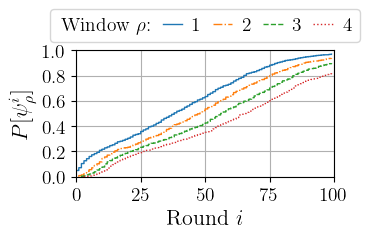

In [85]:
plt.rcParams.update({'font.size': 14})
    
fig, ax = plt.subplots(figsize=(1*width, 0.8*height))
linestyles = ('solid', '-.', 'dashed', 'dotted')
ax.plot(np.nan, np.nan, '', color='none', label=r'Window $\rho$:')
for window in range(1, 5):
    ax.ecdf(data[window - 1], label=window, complementary=False, rasterized=True, linewidth=1, linestyle=linestyles[window - 1])

ax.set_xlabel("Round $i$", fontsize=16)
ax.set_ylabel(r"$P[ \psi_\rho^i ]$", fontsize=16)
ax.set_xlim([0, 100])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0, 1])
# ax.legend(title=r"Window $\rho$", fontsize=11, loc='upper left', bbox_to_anchor=(-0.02,1.03), labelspacing=0.1)
leg = ax.legend(loc='upper center', ncols=5, bbox_to_anchor=(0.5,1.40), handletextpad=0.5, handlelength=1, labelspacing=0.1, columnspacing=0.6)

for vpack in leg._legend_handle_box.get_children()[:1]:
    for hpack in vpack.get_children():
        hpack.get_children()[0].set_width(-5)

ax.grid()
plt.show()
# save_fig(fig, 'bo_window_cdf.pdf')

In [87]:
run_table['cum_sum'] = mlos_table.groupby(['env_id', 'trial'])['cost'].cumsum()
df = run_table.join(ltune_table.cost, on='env_id', rsuffix='_axe')
df = df.join(env_table.writes, on='env_id')
df['delta_regret'] = df['cum_sum'] - df['cost_axe']
df['norm_delta_cost'] = (df['cost'] - df['cost_axe']) / df['cost_axe']

wl_categories = (
    {1: 0}
    | {i: 1 for i in range(2, 6)}
    | {i: 2 for i in range(6, 12)}
    | {i: 3 for i in range(12, 16)}
)
df['wl_type'] = df['env_id'].replace(wl_categories)

min_table = df.loc[df.groupby(['env_id', 'trial']).norm_delta_cost.idxmin()]

AttributeError: 'DataFrame' object has no attribute 'groupby'